In [35]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision.transforms import Compose
import torchvision.transforms as tv_transform
from tqdm import tqdm

from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format('vitl')).to(DEVICE).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))

xFormers not available
xFormers not available


Total parameters: 335.32M


In [28]:
img.shape

(256, 464, 3)

In [73]:
class Resize_new(object):
    """Resize sample to given size (width, height).
    """
    def __init__(
        self,
        width=518,
        height=518,
        img_width = 464,
        img_height = 256,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method="lower_bound",
    ):
        """Init.

        Args:
            width (int): desired output width
            height (int): desired output height

            keep_aspect_ratio (bool, optional):
                True: Keep the aspect ratio of the input sample.
                Output sample might not have the given width and height, and
                resize behaviour depends on the parameter 'resize_method'.
                Defaults to True.

            ensure_multiple_of (int, optional):
                Output width and height is constrained to be multiple of this parameter.
                Defaults to 1.
            resize_method (str, optional):
                "lower_bound": Output will be at least as large as the given size.
                "upper_bound": Output will be at max as large as the given size. (Output size might be smaller than given size.)
                "minimal": Scale as least as possible.  (Output size might be smaller than given size.)
                Defaults to "lower_bound".
        """
        self.__width = width
        self.__height = height


        self.__keep_aspect_ratio = keep_aspect_ratio
        self.__multiple_of = ensure_multiple_of
        self.__resize_method = resize_method

        
        self.width, self.height = self.get_size(img_width, img_height)
        self._resize = tv_transform.Resize((int(self.height), int(self.width)))

    def constrain_to_multiple_of(self, x, min_val=0, max_val=None):
        y = (np.round(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if max_val is not None and y > max_val:
            y = (np.floor(x / self.__multiple_of) * self.__multiple_of).astype(int)

        if y < min_val:
            y = (np.ceil(x / self.__multiple_of) * self.__multiple_of).astype(int)

        return y

    def get_size(self, width, height):
        # determine new height and width
        scale_height = self.__height / height
        scale_width = self.__width / width

        if self.__keep_aspect_ratio:
            if self.__resize_method == "lower_bound":
                # scale such that output size is lower bound
                if scale_width > scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "upper_bound":
                # scale such that output size is upper bound
                if scale_width < scale_height:
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            elif self.__resize_method == "minimal":
                # scale as least as possbile
                if abs(1 - scale_width) < abs(1 - scale_height):
                    # fit width
                    scale_height = scale_width
                else:
                    # fit height
                    scale_width = scale_height
            else:
                raise ValueError(
                    f"resize_method {self.__resize_method} not implemented"
                )

        if self.__resize_method == "lower_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, min_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, min_val=self.__width
            )
        elif self.__resize_method == "upper_bound":
            new_height = self.constrain_to_multiple_of(
                scale_height * height, max_val=self.__height
            )
            new_width = self.constrain_to_multiple_of(
                scale_width * width, max_val=self.__width
            )
        elif self.__resize_method == "minimal":
            new_height = self.constrain_to_multiple_of(scale_height * height)
            new_width = self.constrain_to_multiple_of(scale_width * width)
        else:
            raise ValueError(f"resize_method {self.__resize_method} not implemented")

        return (new_width, new_height)

    def __call__(self, sample):
        sample = self._resize(sample)        
        return sample

In [24]:
518/14

37.0

In [1]:
import torch.nn as nn
from imageio.v2 import imread, imsave
def load_tensor_image(filename):
    
    global DEVICE
    img = imread(filename).astype(np.float32)
    
    h, w, _ = img.shape
    
    img = np.transpose(img, (2, 0, 1))
    tensor_img = ((torch.from_numpy(img).unsqueeze(0)/255-0.5)/0.5).to(DEVICE)
    return tensor_img


class DepthAnythingSFM(nn.Module):
    def __init__(self, encoder='vitl', size=(256, 464)):
        assert encoder in ['vits', 'vitb', 'vitl']
        super(DepthAnythingSFM, self).__init__()
        self.model = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format(encoder)).train()
        self.total_params = sum(param.numel() for param in self.model.parameters())
        print('Total Depth Anything parameters: {:.2f}M'.format(self.total_params / 1e6)) 
        self.transform = Compose([Resize_new()])
        self._size = size
    def forward(self, x):
        x = self.transform(x)
        depth = depth_anything(x)
        depth = torch.tensor(255) - depth
        depth = tv_transform.functional.resize(depth, self._size)

        return depth


model = DepthAnythingSFM('vits')

image = load_tensor_image(filename)
print(f"image shape {image.shape}")
# model(image)

NameError: name 'DepthAnything' is not defined

In [84]:
depth = model(image)

torch.Size([1, 256, 464])


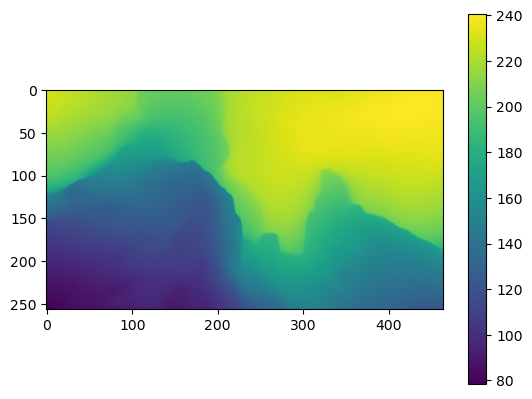

In [85]:
print(depth.shape)
plt.imshow(depth.detach().cpu().squeeze())
plt.colorbar()

In [58]:
transform = Compose([
        # Resize(
        #     width=518,
        #     height=518,
        #     resize_target=False,
        #     keep_aspect_ratio=True,
        #     ensure_multiple_of=14,
        #     resize_method='lower_bound',
        #     image_interpolation_method=cv2.INTER_CUBIC,
        # ),
        
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),
        Resize_new(),
    ])


In [33]:
from path import Path

dir = Path('/mundus/mrahman527/Thesis/data/Eiffel-Tower_ready_Downscaled_colmap/2015')
filenames = dir.glob("*.png")
print(len(filenames))

4914


In [65]:
for filename in tqdm(filenames):
    # raw_image = cv2.imread(filename)
    # image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0
    image = load_tensor_image(filename)
    print(f'image shape original: {image.shape}')
    h, w = image.shape[:2]
    img = image
    
    image = transform({'image': image})['image']
    # image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)
    print(f"transformed shape {image.shape}")
    with torch.no_grad():
        depth = depth_anything(image)
        print(depth.shape)
        print(depth.max())
        print(depth.min())
        
    print(f"depth shape {depth.shape}")
    depth = tv_transform.functional.resize(depth, (256, 464))
    print(f"after interpolate depth shape {depth.shape}")
    # depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    print(depth.shape)
    depth = depth.cpu().numpy().astype(np.uint8)


    break

  0%|          | 0/4914 [00:00<?, ?it/s]/tmp/ipykernel_1334858/2153578348.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(filename).astype(np.float32)


image shape original: torch.Size([1, 3, 256, 464])
torch.Size([1, 3, 256, 464])
transformed shape torch.Size([1, 3, 518, 938])


  0%|          | 0/4914 [00:34<?, ?it/s]

torch.Size([1, 518, 938])
tensor(177.0863)
tensor(12.8610)
depth shape torch.Size([1, 518, 938])
after interpolate depth shape torch.Size([1, 256, 464])
torch.Size([1, 256, 464])


In [27]:
464/256

1.8125

In [21]:
image.shape

torch.Size([1, 3, 518, 938])

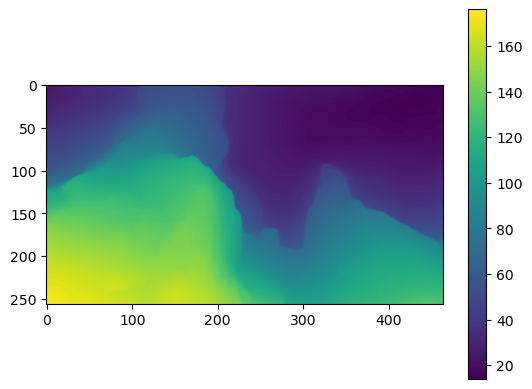

In [67]:

mask = depth>65

import matplotlib.pyplot as plt 
plt.imshow((depth[0]))
# plt.imshow(mask)
plt.colorbar()

In [23]:
plt.imshow(img)

NameError: name 'plt' is not defined

In [20]:
print(filename)

/mundus/mrahman527/Thesis/data/Eiffel-Tower_ready_Downscaled_colmap/2015/20150419T042647.000Z.png


In [1]:
DEPTH_FILE = '/mundus/mrahman527/Thesis/data/scaled_and_cropped_depth/2015/depth_20150419T042647.000Z.png'

gt_depth  = cv2.imread(DEPTH_FILE)
gt_depth = cv2.cvtColor(gt_depth, cv2.COLOR_BGR2GRAY)
    
gt_depth = (gt_depth) / (gt_depth.max()) * 255.0
plt.imshow(gt_depth)
plt.colorbar()

NameError: name 'cv2' is not defined

In [29]:
gt_depth.shape

(256, 464, 3)